In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
df = pd.read_csv("sensor_log-6.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# **Acceleration Sensor**

## Before Filtering

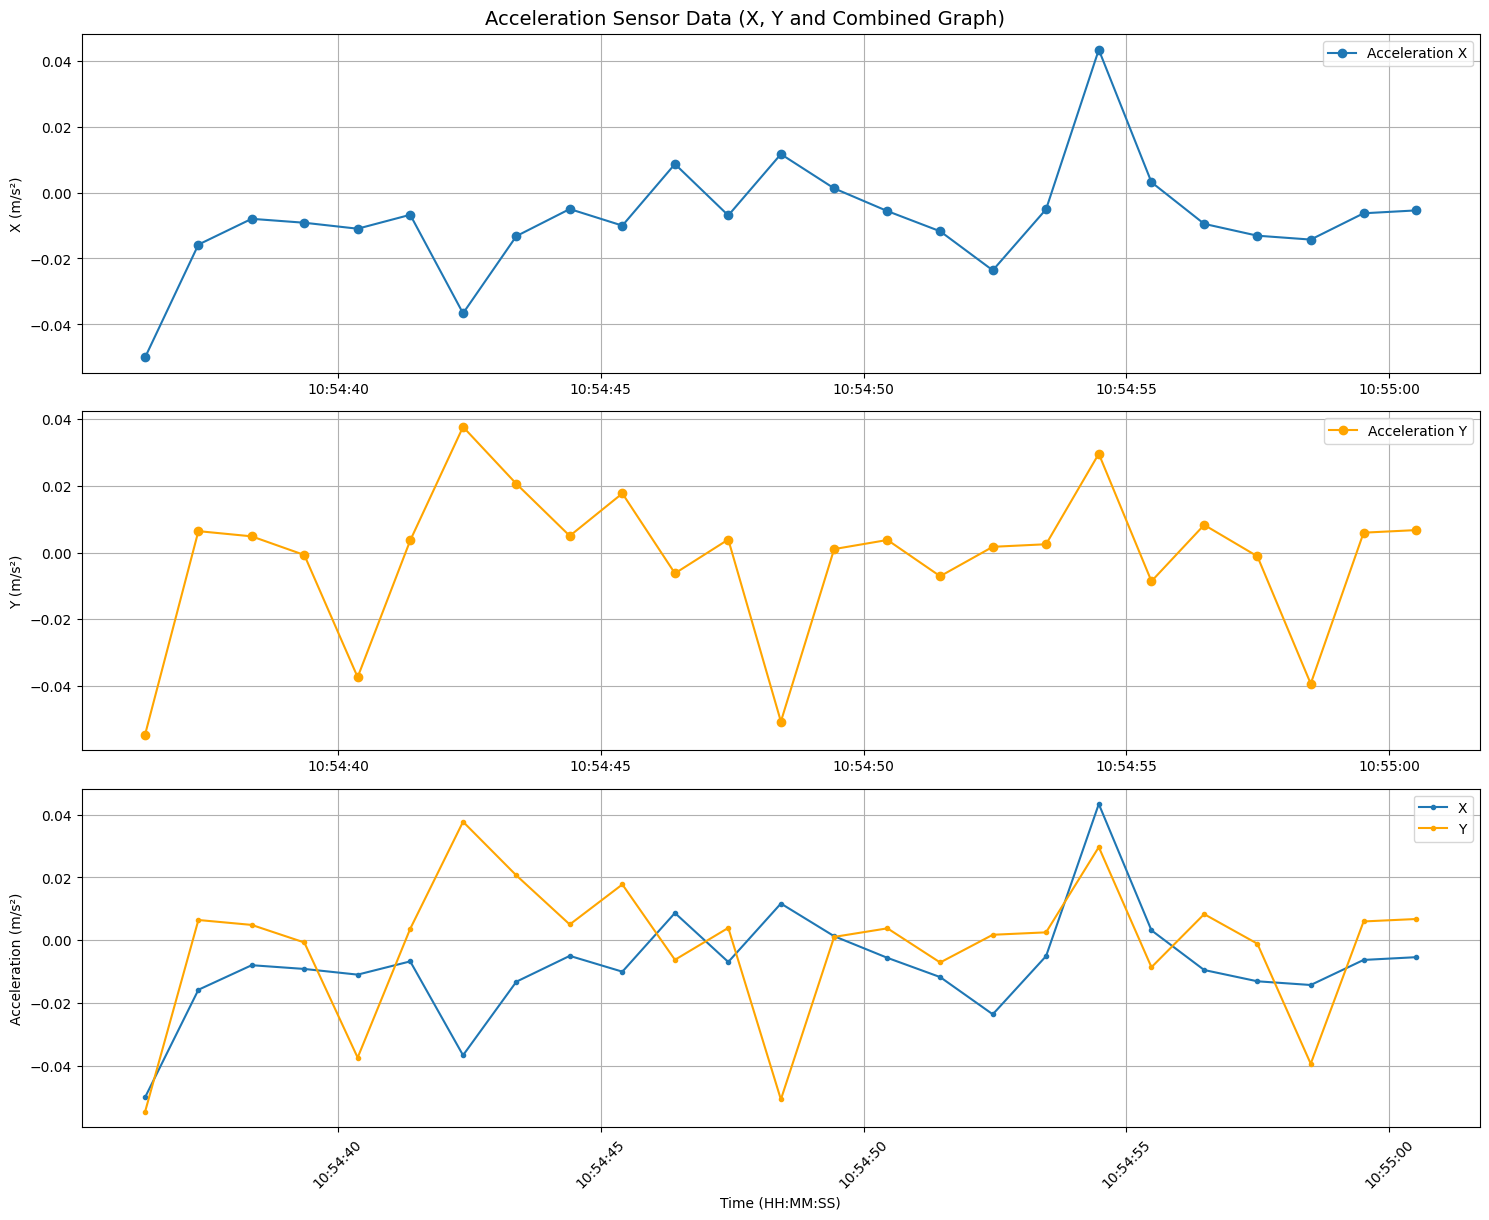

In [4]:
plt.figure(figsize=(15, 12))  # ขยายความสูงอีกหน่อย

# กราฟ 1: acc_x
plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['acc_x'], label='Acceleration X', marker='o')
plt.ylabel('X (m/s²)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# กราฟ 2: acc_y
plt.subplot(3, 1, 2)
plt.plot(df['timestamp'], df['acc_y'], label='Acceleration Y', color='orange', marker='o')
plt.ylabel('Y (m/s²)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


# กราฟ 4: รวม acc_x
plt.subplot(3, 1, 3)
plt.plot(df['timestamp'], df['acc_x'], label='X', marker='.')
plt.plot(df['timestamp'], df['acc_y'], label='Y', marker='.', color='orange')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# ตั้งชื่อกราฟรวม
plt.suptitle('Acceleration Sensor Data (X, Y and Combined Graph)', fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## After Filtering

# **Gyroscope Sensor**

## Before Filtering

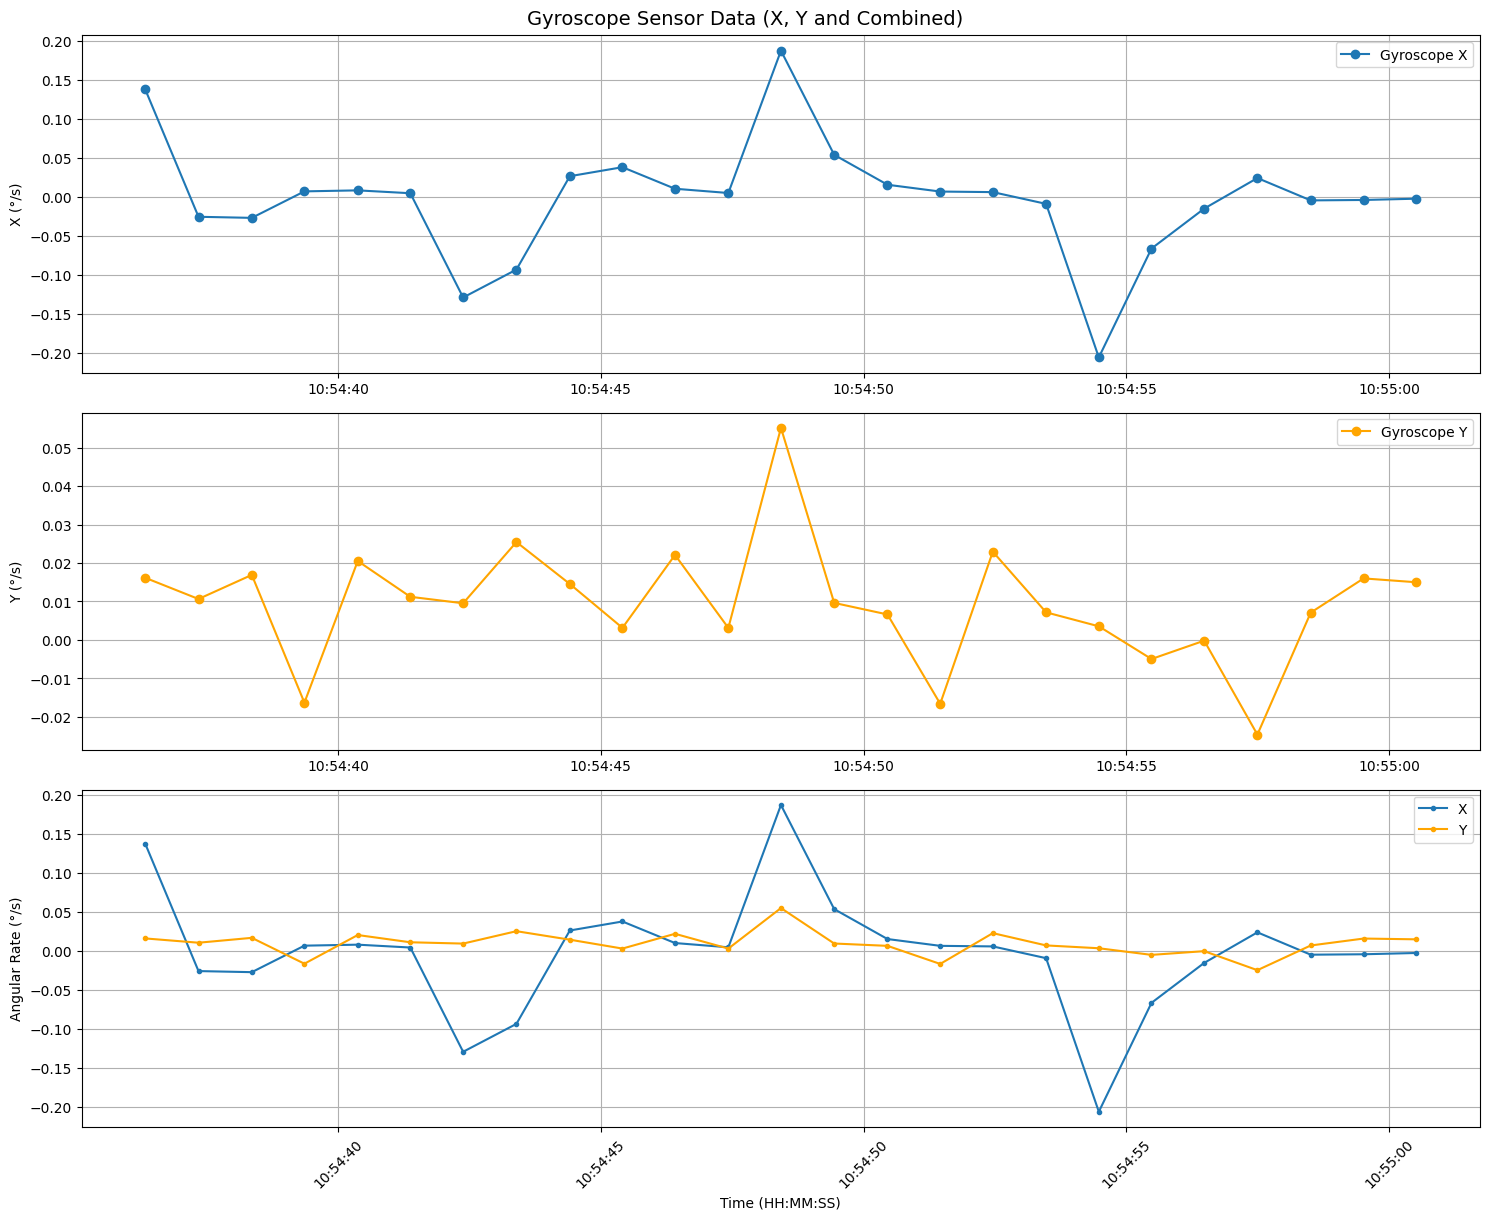

In [5]:

plt.figure(figsize=(15, 12)) 

# Gyro X
plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['gyro_x'], label='Gyroscope X', marker='o')
plt.ylabel('X (°/s)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Gyro Y
plt.subplot(3, 1, 2)
plt.plot(df['timestamp'], df['gyro_y'], label='Gyroscope Y', color='orange', marker='o')
plt.ylabel('Y (°/s)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.subplot(3, 1, 3)
plt.plot(df['timestamp'], df['gyro_x'], label='X', marker='.', linestyle='-')
plt.plot(df['timestamp'], df['gyro_y'], label='Y', marker='.', linestyle='-', color='orange')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('Angular Rate (°/s)')
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Title และ layout
plt.suptitle('Gyroscope Sensor Data (X, Y and Combined)', fontsize=14)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## After Filtering

# **Distance Sensor**

In [6]:
df = pd.read_csv("combined_sensor_data.csv")
df = df[df["tof"] <= 400]
df

,timestamp_iso,tof,gimbal_pitch_angle,gimbal_yaw_angle,gimbal_pitch_ground_angle,gimbal_yaw_ground_angle
0,2025-07-15T10:35:36.049924,164,NaN,NaN,NaN,NaN
1,2025-07-15T10:35:36.232909,164,-1.2,85.2,0.0,86.5
2,2025-07-15T10:35:36.249327,167,-1.2,85.2,0.0,86.5
3,2025-07-15T10:35:36.431410,167,-1.1,79.3,0.0,80.5
4,2025-07-15T10:35:36.447670,177,-1.1,79.3,0.0,80.5
...,...,...,...,...,...,...
63,2025-07-15T10:35:42.583990,199,-0.5,-90.4,0.0,-88.7
64,2025-07-15T10:35:42.583990,199,-0.5,-90.4,0.0,-88.7
65,2025-07-15T10:35:42.763894,197,-0.6,-90.4,0.0,-88.7
66,2025-07-15T10:35:42.763894,197,-0.6,-90.4,0.0,-88.7


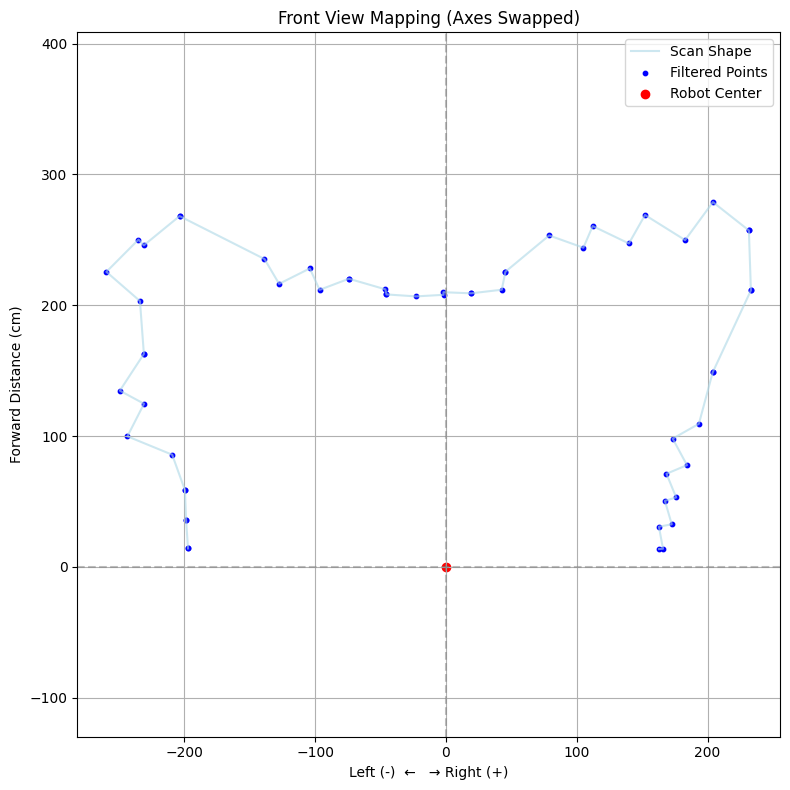

In [9]:
df_clean = df.dropna(subset=['tof', 'gimbal_yaw_angle'])

# จำกัดมุมให้เฉพาะ -90° ถึง +90°
df_filtered = df_clean[(df_clean['gimbal_yaw_angle'] >= -90) & (df_clean['gimbal_yaw_angle'] <= 90)]

# ---------------------------
# 🔍 กรอง Outliers จากข้อมูล ToF ด้วย IQR
q1 = df_filtered['tof'].quantile(0.25)
q3 = df_filtered['tof'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outliers = df_filtered[
    (df_filtered['tof'] >= lower_bound) &
    (df_filtered['tof'] <= upper_bound)
]

yaw_deg = df_no_outliers['gimbal_yaw_angle'].values
yaw_rad = np.radians(yaw_deg)
tof = df_no_outliers['tof'].values

sensor_offset = 8  # cm จากจุดหมุนถึงเซนเซอร์

# คำนวณระยะจากจุดหมุน (ด้วย cosine law)
total_distance = np.sqrt(
    tof**2 + sensor_offset**2 - 2 * tof * sensor_offset * np.cos(yaw_rad)
)

# ---------------------------
# 📐 แปลงเป็นพิกัด XY:
#   - แกน X = ด้านหน้า (Forward)
#   - แกน Y = ซ้าย/ขวา
new_x = total_distance * np.cos(yaw_rad)
new_y = total_distance * np.sin(yaw_rad)

# ---------------------------
# ⚙️ ค่าคงที่
plt.figure(figsize=(8, 8))

# สลับลำดับพิกัดเป็น (new_y, new_x)
plt.plot(new_y, new_x, color='lightblue', alpha=0.6, label='Scan Shape')
plt.scatter(new_y, new_x, c='blue', s=10, label='Filtered Points')

# ตำแหน่งหุ่น (0,0) จะสลับตามแกนใหม่
plt.scatter(0, 0, c='red', label='Robot Center')

# เส้นแกน
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

# ตั้งค่าแกนใหม่
plt.title("Front View Mapping (Axes Swapped)")
plt.xlabel("Left (-)  ←   → Right (+)")   # new_y อยู่แกน X
plt.ylabel("Forward Distance (cm)")        # new_x อยู่แกน Y
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()